# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [81]:
import numpy as np
from glob import glob

# load filenames for human and dog images
#human_files = np.array(glob("/data/lfw/*/*"))
#dog_files = np.array(glob("/data/dog_images/*/*/*"))

human_files = np.array(glob("/Users/garimaaggarwal/Documents/dbc/data/lfw/*/*"))
dog_files = np.array(glob("/Users/garimaaggarwal/Documents/dbc/data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [82]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

In [83]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/Users/garimaaggarwal/Documents/dbc/haarcascades/haarcascade_frontalface_alt.xml')
print ((human_files.shape[0]))

13233


Number of faces detected: 1


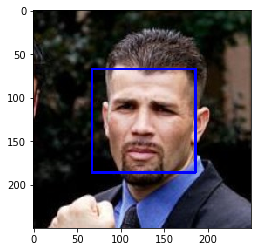

In [85]:

# load color (BGR) image
# generate a random number to load the image and test the face detector
random_number= np.random.randint(0,human_files.shape[0])
img = cv2.imread(human_files[random_number])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# find faces in image
faces = face_cascade.detectMultiScale(gray)
# print number of faces detected in the image
print('Number of faces detected:', len(faces))
# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [86]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 200 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [87]:
from tqdm import tqdm

human_files_short = human_files[:200]
dog_files_short = dog_files[:200]
human_faces =0
for image in human_files_short:
    if face_detector(image):
        human_faces +=1
print (human_faces)
human_in_dog_face = 0
for image in dog_files_short:
    if face_detector(image):
        human_in_dog_face +=1
print (human_in_dog_face)
    

197
25


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [88]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    print ("Cuda available")
    VGG16 = VGG16.cuda()


In [89]:
print (type(VGG16))
print (use_cuda)
#print (human_files_short.device)

<class 'torchvision.models.vgg.VGG'>
False


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [90]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    '''
    transform to size 224x224, normalize
    '''
    # Open image
    dog_img = Image.open(img_path)
    # Tranforms
    transform = transforms.Compose([
        transforms.Resize(256),                   
        transforms.CenterCrop(224),                
        transforms.ToTensor(),                     
        transforms.Normalize(  
            
            mean=[0.485, 0.456, 0.406],                
            std=[0.229, 0.224, 0.225] 
            
    )])
    
    img_transformed = transform(dog_img)
    # convert numpy image to tensor
    #img_transformed = torch.from_numpy(img_transformed).float().to(device)
    
    #Define a batch to be passed through the network
    batch_t = torch.unsqueeze(img_transformed, 0)
    
    VGG16.eval()
    output = VGG16(batch_t)
    #print (output.shape)
    max_val, index = torch.max(output,1)
    return index
    #index where the maximum score in output vector out occurs
       
    #return img_transformed # predicted class index
#img = VGG16_predict(dog_files[200])
#print (img)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

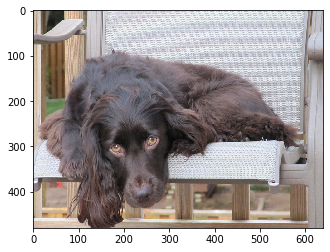

Image net class number
tensor([219])


In [91]:
random_number = np.random.randint(0, dog_files.shape[0])
dog_image = cv2.imread(dog_files[random_number])
dog_image = cv2.cvtColor(dog_image, cv2.COLOR_BGR2RGB)
plt.imshow(dog_image)
plt.show()
img = VGG16_predict(dog_files[random_number])
print ("Image net class number")
print (img)

In [92]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predicted_index = VGG16_predict(img_path)
    if predicted_index >= 151 and  predicted_index <= 268:
        return True
    return False
    

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [93]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_faces =0
for image in human_files_short:
    if dog_detector(image):
        human_faces +=1
print (human_faces)
dog_faces = 0
for image in dog_files_short:
    if dog_detector(image):
        dog_faces +=1
print (dog_faces)

3
196


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel

<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador

<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [94]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/'
test_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/test/'
valid_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/valid/'


### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Data set directories
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
#print (type(train_data))

batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

# get the classes or dog breeds
classes = list(np.array(glob("/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/*")))

Num training images:  6680
Num test images:  836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:Resized and cropped the images so that all images are of same size. Augmented data by random horizontal flipping and rotation.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [95]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer
        '''
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*28*28, 512) 
        self.fc2 = nn.Linear(512, 133) 
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Dropout
        self.dropout = nn.Dropout(0.20)
        '''
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128,3, padding=1)
        self.fc1 = nn.Linear(128*14*14, 512) 
        self.fc2 = nn.Linear(512, 133) 
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Dropout
        self.dropout = nn.Dropout(0.25)

  
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 128*14*14)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        #x = F.softmax(self.fc2(x))
        x = self.fc2(x)
        return x

        

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ TRIAL AND ERROR

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [96]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [97]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
           
            
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            ## change according to batch size
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [98]:
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch 1, Batch 1 loss: 4.890872
Epoch 1, Batch 101 loss: 4.890386
Epoch 1, Batch 201 loss: 4.885545
Epoch 1, Batch 301 loss: 4.879847
Epoch: 1 	Training Loss: 4.877640 	Validation Loss: 4.831824
Validation loss decreased (inf --> 4.831824).  Saving model ...
Epoch 2, Batch 1 loss: 4.765559
Epoch 2, Batch 101 loss: 4.810202
Epoch 2, Batch 201 loss: 4.801051
Epoch 2, Batch 301 loss: 4.783059
Epoch: 2 	Training Loss: 4.774116 	Validation Loss: 4.659518
Validation loss decreased (4.831824 --> 4.659518).  Saving model ...
Epoch 3, Batch 1 loss: 4.517199
Epoch 3, Batch 101 loss: 4.645823
Epoch 3, Batch 201 loss: 4.647873
Epoch 3, Batch 301 loss: 4.638758
Epoch: 3 	Training Loss: 4.632407 	Validation Loss: 4.568426
Validation loss decreased (4.659518 --> 4.568426).  Saving model ...
Epoch 4, Batch 1 loss: 4.809060
Epoch 4, Batch 101 loss: 4.573340
Epoch 4, Batch 201 loss: 4.585113
Epoch 4, Batch 301 loss: 4.581917
Epoch: 4 	Training Loss: 4.581147 	Validation Loss: 4.563212
Validation loss de

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [99]:
'''
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

'''
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    


In [100]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.868453


Test Accuracy: 11% (92/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [101]:
## TODO: Specify data loaders
import os
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/'
test_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/test/'
valid_dir = '/Users/garimaaggarwal/Documents/dbc/data/dogImages/valid/'

# classes are folders in each directory with these names
#classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Data set directories
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
#print (type(train_data))

batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_transfer={
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
    
}
# get the classes or dog breeds
classes = list(np.array(glob("/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/*")))
print (classes)

Num training images:  6680
Num test images:  836
['/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/122.Pointer', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/069.French_bulldog', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/124.Poodle', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/112.Nova_scotia_duck_tolling_retriever', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/043.Canaan_dog', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/024.Bichon_frise', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/036.Briard', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/086.Irish_setter', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/078.Great_dane', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/061.English_cocker_spaniel', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/075.Glen_of_imaal_terrier', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/train/089.Irish_wolfhound', '

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [102]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.vgg16(pretrained=True)
if use_cuda:
    model_transfer = model_transfer.cuda()

In [103]:
print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
#Modify the last layer fully connected layer
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
#if train_on_gpu:
    #model_transfer.cuda()

# check to see that last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)


4096
1000
133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [104]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [105]:
# train the model
n_epochs = 10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1, Batch 1 loss: 5.031547
Epoch 1, Batch 101 loss: 4.859499
Epoch 1, Batch 201 loss: 4.697561
Epoch 1, Batch 301 loss: 4.529002
Epoch: 1 	Training Loss: 4.470652 	Validation Loss: 3.785236
Validation loss decreased (inf --> 3.785236).  Saving model ...
Epoch 2, Batch 1 loss: 4.346393
Epoch 2, Batch 101 loss: 3.656234
Epoch 2, Batch 201 loss: 3.462609
Epoch 2, Batch 301 loss: 3.311067
Epoch: 2 	Training Loss: 3.260581 	Validation Loss: 2.575662
Validation loss decreased (3.785236 --> 2.575662).  Saving model ...
Epoch 3, Batch 1 loss: 2.378476
Epoch 3, Batch 101 loss: 2.620509
Epoch 3, Batch 201 loss: 2.469587
Epoch 3, Batch 301 loss: 2.410905
Epoch: 3 	Training Loss: 2.384020 	Validation Loss: 1.885198
Validation loss decreased (2.575662 --> 1.885198).  Saving model ...
Epoch 4, Batch 1 loss: 1.610661
Epoch 4, Batch 101 loss: 2.060158
Epoch 4, Batch 201 loss: 2.027245
Epoch 4, Batch 301 loss: 1.996137
Epoch: 4 	Training Loss: 1.975693 	Validation Loss: 1.600922
Validation loss de

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [108]:
#test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)
print("done")

Test Loss: 1.256128


Test Accuracy: 65% (548/836)
done


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [117]:
'''
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None
    
'''
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
import torchvision.transforms as transforms
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
#print(class_names)
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # Open image
    dog_img = Image.open(img_path)
    # Tranforms
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),                                   
        transforms.ToTensor(),                     
        transforms.Normalize(  
            
            mean=[0.485, 0.456, 0.406],                
            std=[0.229, 0.224, 0.225] 
            
    )])
    
    img_transformed = transform(dog_img)
    
    #Define a batch to be passed through the network
    batch_t = torch.unsqueeze(img_transformed, 0)
    
    model_transfer.eval()
    output = model_transfer(batch_t)
    #print (output.shape)
    #max_val, index = torch.max(output,1)
    idx = torch.argmax(output)
    return class_names[idx]
    
    
    

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [118]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(img_path)
        print("Dogs Detected!\nIt appears to be a {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(img_path)
        print("Hello, there buddy!\n If you were a dog..You may resemble a {0}".format(prediction))
    else:
        print("Error! .. It appears that the dog and the hooman have gone for a walk..nothing detected here")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

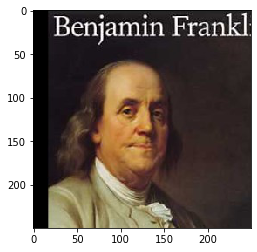

Hello, there buddy!
 If you were a dog..You may resemble a Brittany


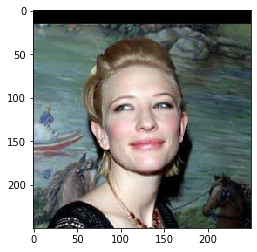

Hello, there buddy!
 If you were a dog..You may resemble a Chinese crested


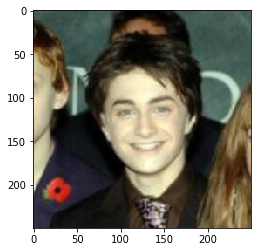

Hello, there buddy!
 If you were a dog..You may resemble a Dachshund


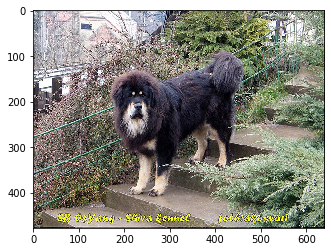

Dogs Detected!
It appears to be a Tibetan mastiff


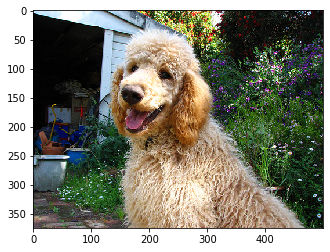

Dogs Detected!
It appears to be a Cocker spaniel


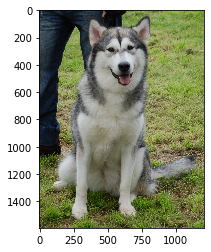

Dogs Detected!
It appears to be a Icelandic sheepdog


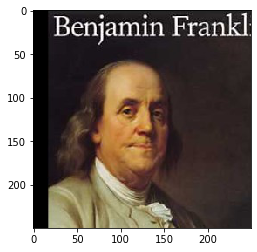

Hello, there buddy!
 If you were a dog..You may resemble a Dogue de bordeaux


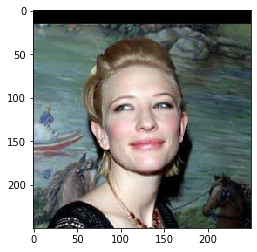

Hello, there buddy!
 If you were a dog..You may resemble a Plott


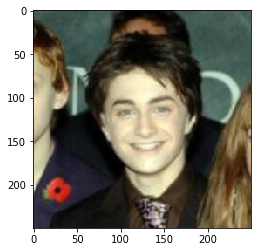

Hello, there buddy!
 If you were a dog..You may resemble a English toy spaniel


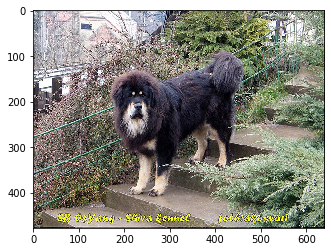

Dogs Detected!
It appears to be a Tibetan mastiff


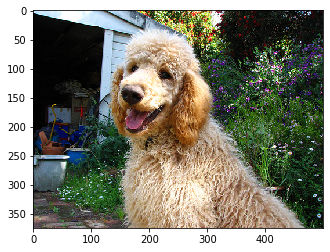

Dogs Detected!
It appears to be a Poodle


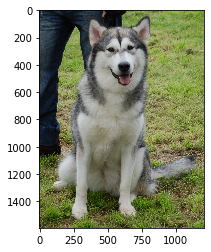

Dogs Detected!
It appears to be a Alaskan malamute


In [122]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
#human_files = ['lfw/lfw/Brad_Pitt/Brad_Pitt_0001.jpg', 'lfw/lfw/Cate_Blanchett/Cate_Blanchett_0001.jpg', 'lfw/lfw/Daniel_Radcliffe/Daniel_Radcliffe_0003.jpg' ]
#dog_files = ['dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg', 'dogImages/test/129.Tibetan_mastiff/124.Poodle/Poodle_07910.jpg', 'dogImages/test/129.Tibetan_mastiff/005.Alaskan_malamute/Alaskan_malamute_00346.jpg']
human_files = ['/Users/garimaaggarwal/Documents/dbc/data/lfw/Benjamin_Franklin/Benjamin_Franklin_0001.jpg', '/Users/garimaaggarwal/Documents/dbc/data/lfw/Cate_Blanchett/Cate_Blanchett_0001.jpg', '/Users/garimaaggarwal/Documents/dbc/data/lfw/Daniel_Radcliffe/Daniel_Radcliffe_0003.jpg' ]
dog_files = ['/Users/garimaaggarwal/Documents/dbc/data/dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/test/124.Poodle/Poodle_07910.jpg', '/Users/garimaaggarwal/Documents/dbc/data/dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00346.jpg']

for file in np.hstack((human_files, dog_files)):
    run_app(file)
    
## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)